## Detailed Article Explaination

The detailed code explanation for this article is available at the following link:

https://www.daniweb.com/programming/computer-science/tutorials/542711/question-answering-over-sql-data-using-langgraph-framework

For my other articles for Daniweb.com, please see this link:

https://www.daniweb.com/members/1235222/usmanmalik57

## Importing and Installing Required Libraries

In [ ]:
!pip install langchain-community
!pip install langchain-openai
!pip install langgraph

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.4/2.4 MB 29.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 37.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 409.5/409.5 kB 21.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.1/3.1 MB 53.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.5/49.5 kB 3.2 MB/s eta 0:00:00
  Attempting uninstall: SQLAlchemy
    Found existing installation: SQLAlchemy 2.0.36
    Uninstalling SQLAlchemy-2.0.36:
      Successfully uninstalled SQLAlchemy-2.0.36
  Attempting uninstall: langchain-core
    Found existing installation: langchain-core 0.3.19
    Uninstalling langchain-core-0.3.19:
      Successfully uninstalled langchain-core-0.3.19
  Attempting uninstall: langchain
    Found existing installation: langchain 0.3.7
    Uninstalling langchain-0.3.7:
      Successfully uninstalled langchain-0.3.7
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.6/50.6 kB 3.0 MB/s eta 0:00:00
   ━━━━━━━

In [ ]:
import sqlite3
import pandas as pd
import csv
import os

from langchain_community.utilities import SQLDatabase
from langchain_community.tools.sql_database.tool import QuerySQLDataBaseTool
from langchain_openai import ChatOpenAI
from langchain import hub
from langgraph.graph import START, StateGraph

from typing_extensions import Annotated
from IPython.display import Image, display

from google.colab import userdata
os.environ["OPENAI_API_KEY"] = userdata.get('OPENAI_API_KEY')

## Creating a Dummy SQLite Database

In [ ]:
dataset = pd.read_csv('Titanic-Dataset.csv')
dataset.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [ ]:
import pandas as pd
import sqlite3

def csv_to_sqlite(csv_file_path, database_name):
    """
    Converts a CSV file into an SQLite database with proper column names from the CSV headers.

    Parameters:
        csv_file_path (str): Path to the CSV file.
        database_name (str): Name of the SQLite database to create (e.g., 'output.db').

    Returns:
        str: Message indicating success or failure.
    """
    try:
        # Read the CSV file into a pandas DataFrame with headers
        df = pd.read_csv(csv_file_path)

        # Connect to SQLite database (or create it if it doesn't exist)
        conn = sqlite3.connect(database_name)

        # Use the CSV file name (without extension) as the table name
        table_name = csv_file_path.split('/')[-1].split('.')[0]

        # Write the DataFrame to the SQLite database with headers as column names
        df.to_sql(table_name, conn, if_exists='replace', index=False)

        # Close the connection
        conn.close()

        return f"Data from '{csv_file_path}' has been successfully stored in '{database_name}', table '{table_name}'."

    except Exception as e:
        return f"An error occurred: {e}"

# Example usage
csv_file = 'Titanic-Dataset.csv'  # Replace with your CSV file path
database = 'titanic.db'  # Replace with your desired SQLite database name
result = csv_to_sqlite(csv_file, database)
print(result)


Data from 'Titanic-Dataset.csv' has been successfully stored in 'titanic.db', table 'Titanic-Dataset'.


In [ ]:
db = SQLDatabase.from_uri("sqlite:////content/titanic.db")
print(db.dialect)
print(db.get_table_info())
print(db.get_usable_table_names())
db.run("SELECT * FROM 'Titanic-Dataset' LIMIT 10;")

sqlite

CREATE TABLE "Titanic-Dataset" (
	"PassengerId" INTEGER, 
	"Survived" INTEGER, 
	"Pclass" INTEGER, 
	"Name" TEXT, 
	"Sex" TEXT, 
	"Age" REAL, 
	"SibSp" INTEGER, 
	"Parch" INTEGER, 
	"Ticket" TEXT, 
	"Fare" REAL, 
	"Cabin" TEXT, 
	"Embarked" TEXT
)

/*
3 rows from Titanic-Dataset table:
PassengerId	Survived	Pclass	Name	Sex	Age	SibSp	Parch	Ticket	Fare	Cabin	Embarked
1	0	3	Braund, Mr. Owen Harris	male	22.0	1	0	A/5 21171	7.25	None	S
2	1	1	Cumings, Mrs. John Bradley (Florence Briggs Thayer)	female	38.0	1	0	PC 17599	71.2833	C85	C
3	1	3	Heikkinen, Miss. Laina	female	26.0	0	0	STON/O2. 3101282	7.925	None	S
*/
['Titanic-Dataset']


"[(1, 0, 3, 'Braund, Mr. Owen Harris', 'male', 22.0, 1, 0, 'A/5 21171', 7.25, None, 'S'), (2, 1, 1, 'Cumings, Mrs. John Bradley (Florence Briggs Thayer)', 'female', 38.0, 1, 0, 'PC 17599', 71.2833, 'C85', 'C'), (3, 1, 3, 'Heikkinen, Miss. Laina', 'female', 26.0, 0, 0, 'STON/O2. 3101282', 7.925, None, 'S'), (4, 1, 1, 'Futrelle, Mrs. Jacques Heath (Lily May Peel)', 'female', 35.0, 1, 0, '113803', 53.1, 'C123', 'S'), (5, 0, 3, 'Allen, Mr. William Henry', 'male', 35.0, 0, 0, '373450', 8.05, None, 'S'), (6, 0, 3, 'Moran, Mr. James', 'male', None, 0, 0, '330877', 8.4583, None, 'Q'), (7, 0, 1, 'McCarthy, Mr. Timothy J', 'male', 54.0, 0, 0, '17463', 51.8625, 'E46', 'S'), (8, 0, 3, 'Palsson, Master. Gosta Leonard', 'male', 2.0, 3, 1, '349909', 21.075, None, 'S'), (9, 1, 3, 'Johnson, Mrs. Oscar W (Elisabeth Vilhelmina Berg)', 'female', 27.0, 0, 2, '347742', 11.1333, None, 'S'), (10, 1, 2, 'Nasser, Mrs. Nicholas (Adele Achem)', 'female', 14.0, 1, 0, '237736', 30.0708, None, 'C')]"

## Developing a LangGraph Agent for Question/Answering Over SQL Data

### Defining the Agent State and LLM

In [ ]:
from typing_extensions import TypedDict


class State(TypedDict):
    question: str
    query: str
    result: str
    answer: str

In [ ]:
llm = ChatOpenAI(model="gpt-4o")

### Convert Natural Languge Questions to SQL Query

In [ ]:
from langchain import hub

query_prompt_template = hub.pull("langchain-ai/sql-query-system-prompt")

assert len(query_prompt_template.messages) == 1
query_prompt_template.messages[0].pretty_print()

/usr/local/lib/python3.10/dist-packages/langsmith/client.py:241: LangSmithMissingAPIKeyWarning: API key must be provided when using hosted LangSmith API
  warnings.warn(


================================ System Message ================================

Given an input question, create a syntactically correct {dialect} query to run to help find the answer. Unless the user specifies in his question a specific number of examples they wish to obtain, always limit your query to at most {top_k} results. You can order the results by a relevant column to return the most interesting examples in the database.

Never query for all the columns from a specific table, only ask for a the few relevant columns given the question.

Pay attention to use only the column names that you can see in the schema description. Be careful to not query for columns that do not exist. Also, pay attention to which column is in which table.

Only use the following tables:
{table_info}

Question: {input}


In [ ]:
class QueryOutput(TypedDict):
    """Generated SQL query."""

    query: Annotated[str, ..., "Syntactically valid SQL query."]


def convert_question_to_query(state: State):
    """Generate SQL query to fetch information."""
    prompt = query_prompt_template.invoke(
        {
            "dialect": db.dialect,
            "top_k": 10,
            "table_info": db.get_table_info(),
            "input": state["question"],
        }
    )
    structured_llm = llm.with_structured_output(QueryOutput)
    result = structured_llm.invoke(prompt)
    return {"query": result["query"]}

In [ ]:
question = {"question": "How many male passengers are there in the dataset"}
query = convert_question_to_query(question)
print(query)

{'query': 'SELECT COUNT(PassengerId) FROM "Titanic-Dataset" WHERE Sex = \'male\';'}


### Execute SQL Queries

In [ ]:
def execute_query(state: State):
    """Execute SQL query."""
    execute_query_tool = QuerySQLDataBaseTool(db=db)
    return {"result": execute_query_tool.invoke(state["query"])}

result = execute_query(query)
print(result)

{'result': '[(577,)]'}


In [ ]:
dataset["Sex"].value_counts()

,count
Sex,
male,577
female,314


### Generate Final Response

In [ ]:
def generate_answer(state: State):
    """Answer question using retrieved information as context."""
    prompt = (
        "Given the following user question, corresponding SQL query, "
        "and SQL result, answer the user question.\n\n"
        f'Question: {state["question"]}\n'
        f'SQL Query: {state["query"]}\n'
        f'SQL Result: {state["result"]}'
    )
    response = llm.invoke(prompt)
    return {"answer": response.content}

### Adding Nodes to LangGraph and Generating Response

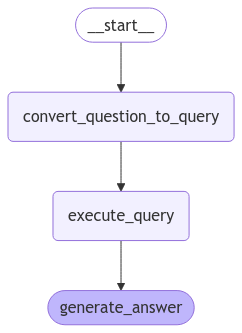

In [ ]:
graph_builder = StateGraph(State).add_sequence(
    [convert_question_to_query, execute_query, generate_answer]
)
graph_builder.add_edge(START, "convert_question_to_query")
graph = graph_builder.compile()

display(Image(graph.get_graph().draw_mermaid_png()))

In [ ]:
def generate_stream_response(question):
  for step in graph.stream(question, stream_mode="updates"):
    print(step)

In [ ]:
question = {"question": "How many male passengers are there in the dataset"}
generate_stream_response(question)

{'convert_question_to_query': {'query': 'SELECT COUNT(PassengerId) AS MalePassengerCount FROM "Titanic-Dataset" WHERE Sex = \'male\';'}}
{'execute_query': {'result': '[(577,)]'}}
{'generate_answer': {'answer': 'There are 577 male passengers in the dataset.'}}


In [ ]:
question = {"question": "What is the average age of male passengers?"}
generate_stream_response(question)

{'convert_question_to_query': {'query': 'SELECT AVG(Age) AS AverageAge FROM "Titanic-Dataset" WHERE Sex = \'male\''}}
{'execute_query': {'result': '[(30.72664459161148,)]'}}
{'generate_answer': {'answer': 'The average age of male passengers is approximately 30.73 years.'}}


In [ ]:
final_answer = graph.invoke(question)
print(final_answer['answer'])

The average age of male passengers is approximately 30.73 years.
